## Local ADCP Particle test with CMEMS data

In [1]:
from datetime import timedelta
import numpy as np
import math

from parcels import (
    ErrorCode,
    FieldSet,
    JITParticle,
    ParticleSet,
    Variable,
)

In [6]:
# # Example for function from https://github.com/OceanParcels/parcels/blob/0f396703be2804f8eaf12b10d1ec1c978af812b3/performance/example_performanceProfiling.py#L76
# import os
# from glob import glob

# def set_cmems_fieldset(cs, deferLoadFlag=True, periodicFlag=False):
#     ddir_head = "/Users/0448257/Data"
#     ddir = os.path.join(ddir_head, "CMEMS/")
#     files = sorted(glob(ddir+"glo12_rg_1d-m_2021010*.nc"))
#     variables = {'U': 'uo', 'V': 'vo'}
#     dimensions = {'lon': 'longitude', 'lat': 'latitude', 'time': 'time'}

#     if cs not in ['auto', False]:
#         # cs = (1, cs, cs) # == OLD initialization as tuple. Advised to rather use a dictionary. ==#
#         cs = {dimensions['time']: 1, dimensions['lon']: cs, dimensions['lat']: cs}
#     if periodicFlag:
#         return FieldSet.from_netcdf(files, variables, dimensions, time_periodic=timedelta(days=30), deferred_load=deferLoadFlag, field_chunksize=cs)
#     else:
#         return FieldSet.from_netcdf(files, variables, dimensions, allow_time_extrapolation=True, deferred_load=deferLoadFlag, field_chunksize=cs)

# fieldset = set_cmems_fieldset(False)

### Read sample input data

In [3]:
# Load the CMEMS data (3 days manually downloaded)
example_dataset_folder = "../Data"
filenames = {
    "U": f"{example_dataset_folder}/glo12_rg_1d-m_2021010*_3D-uovo_hcst_R20210113.nc",
    "V": f"{example_dataset_folder}/glo12_rg_1d-m_2021010*_3D-uovo_hcst_R20210113.nc",
    "S": f"{example_dataset_folder}/glo12_rg_1d-m_2021010*_3D-so_hcst_R20210113.nc",
    "T": f"{example_dataset_folder}/glo12_rg_1d-m_2021010*_3D-thetao_hcst_R20210113.nc",
}
variables = {'U': 'uo', 'V': 'vo', 'S':'so', 'T':'thetao'}
dimensions = {'lon': 'longitude', 'lat': 'latitude', 'time': 'time', 'depth':'depth'}
fieldset = FieldSet.from_netcdf(filenames, variables, dimensions, time_periodic=timedelta(days=3))

# uppermost layer in the hydrodynamic data
fieldset.mindepth = fieldset.U.depth[0]
print(fieldset.mindepth)

# set initial location
ini_lat = -31
ini_lon = 32

0.494025


### Create particles and initalize

In [4]:
# Create and initialize Variable particles to sample the ocean
class SampleParticleInitZero(JITParticle):
    """Define a new particle class with Variables init 0"""
    salinity = Variable("salinity", initial=0)
    temperature = Variable("temperature", initial=0)
    U = Variable('U', dtype=np.float32, initial=np.nan)
    V = Variable('V', dtype=np.float32, initial=np.nan)

# define function sampling Salinity 
def SampleS(particle, fieldset, time):
    particle.salinity = fieldset.S[time, particle.depth, particle.lat, particle.lon]

# define function sampling Temperature 
def SampleT(particle, fieldset, time):
    particle.temperature = fieldset.T[time, particle.depth, particle.lat, particle.lon]

# define function sampling u and v as in https://docs.oceanparcels.org/en/latest/examples/tutorial_sampling.html
def SampleVel_correct(particle, fieldset, time):
    particle.U, particle.V = fieldset.UV[time, particle.depth, particle.lat, particle.lon, particle]

# Attempt for ADCP like particle TODO accurate depths 
depthnum = 30
# Initiate ADCP like particle set 
pset = ParticleSet.from_list(
    fieldset=fieldset, pclass=SampleParticleInitZero, lon=np.full(depthnum,ini_lon), lat=np.full(depthnum,ini_lat), depth=np.linspace(5, 1000, num=depthnum)
)

Sample_S_kernel = pset.Kernel(SampleS)  # Casting the SampleS function to a kernel.
Sample_T_kernel = pset.Kernel(SampleT)  # similar for temperature
SampleVel_kernel = pset.Kernel(SampleVel_correct)  # Casting the function to a kernel.

# only execute the sampling kernels to record the init temp of the particles
pset.execute(Sample_S_kernel, dt=0)
pset.execute(Sample_T_kernel, dt=0)
pset.execute(SampleVel_kernel, dt=0)

INFO: Compiled ArraySampleParticleInitZeroSampleS ==> /tmp/parcels-382783/lib45ac30e829f5354904253e0c9bfec45f_0.so
INFO: Compiled ArraySampleParticleInitZeroSampleT ==> /tmp/parcels-382783/lib274d8ae72420a16131edca44f12f7cf2_0.so


TypeError: ParticleSetSOA.Kernel() got an unexpected keyword argument 'dt'

### Determine ship course and add as kernel 

In [5]:
# change advection to ship movement
# Cruising speed Pelagia (and Anna Weber) is 9 knp https://www.nioz.nl/application/files/3614/9744/8746/Pelagia_Technical_specifications-2016.pdf
# survey speed nog iets lager? Zoals bij https://schmidtocean.org/rv-falkor/ship-specifications/
# 7 knp = 13 km/h = 3.6 m/s

def ShipVel(particle, fieldset, time):
    speed = 3.6
    target_lat = -50
    target_lon = 20
    # determine ship direction
    heading = math.sqrt((target_lat - particle.lat)**2 + (target_lon - particle.lon)**2)
    # calculate e/w and n/s speed (m/s)
    lat_add = (target_lat - particle.lat)/(heading/speed)
    lon_add = (target_lon - particle.lon)/(heading/speed)
    # convert to lat/lon
    lat_add_deg = lat_add / 1.11e5
    lon_add_deg = lon_add / (1.11e5 * math.cos(particle.lat * math.pi / 180))
    # add to particle position
    particle.lat += lat_add_deg * particle.dt
    particle.lon += lon_add_deg * particle.dt

# cast the ships velocity function to a kernel object
ShipVel_kernel = pset.Kernel(ShipVel)

### Run simulation

In [6]:
# set output file name and dt
output_file = pset.ParticleFile(
    name="ADCPtest.zarr",  # the file name
    outputdt=timedelta(hours=1),  # the time step of the outputs
)

# Choose which kernels to use
kernels = ShipVel_kernel + Sample_S_kernel + Sample_T_kernel + SampleVel_kernel

# Execute code and save to file 
pset.execute(
    kernels, 
    runtime=timedelta(days=1),  # the total length of the run
    dt=timedelta(minutes=60),  # the timestep of the kernel
    output_file=output_file,
)

INFO: Compiled ArraySampleParticleInitZeroShipVelSampleSSampleTSampleVel_correct ==> /tmp/parcels-382783/lib057c17877b184be2fe6a44f0844c423d_0.so
INFO: Output files are stored in ADCPtest.zarr.
100%|██████████| 86400.0/86400.0 [02:32<00:00, 566.27it/s] 


### Do some plotting to check output

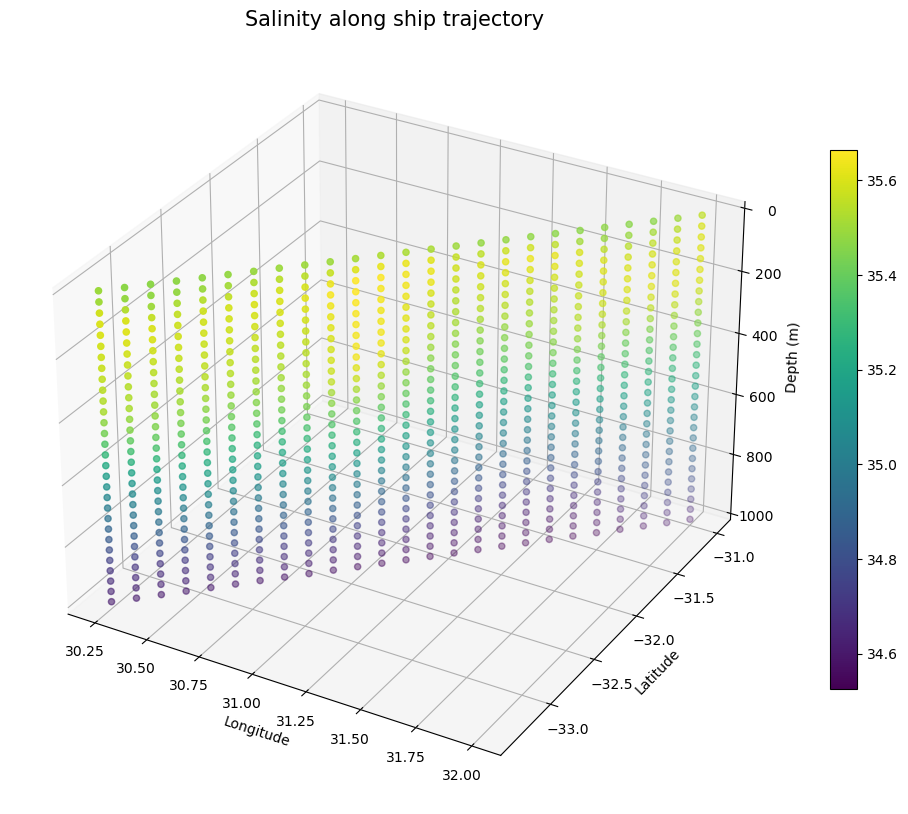

In [2]:
import matplotlib.pyplot as plt
import xarray as xr

# Open output and read to x, y, z
ds = xr.open_zarr("ADCPtest.zarr")
x = ds["lon"][:].squeeze()
y = ds["lat"][:].squeeze()
z = ds["z"][:].squeeze()
U = ds["U"][:].squeeze()
V = ds["V"][:].squeeze()
S = ds["salinity"][:].squeeze()
T = ds["temperature"][:].squeeze()
ds.close()

# Plot Particle depth
fig = plt.figure(figsize=(13, 10))
ax = plt.axes(projection="3d")
cb = ax.scatter(x, y, z, c=S, s=20, marker="o")
ax.set_title('Salinity along ship trajectory', size=15)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_zlabel("Depth (m)")
ax.set_zlim(np.max(z), 0)
plt.colorbar(cb, shrink = 0.7)
plt.show()

In [45]:
print(ds)

<xarray.Dataset>
Dimensions:      (trajectory: 10, obs: 73)
Coordinates:
  * obs          (obs) int32 0 1 2 3 4 5 6 7 8 9 ... 64 65 66 67 68 69 70 71 72
  * trajectory   (trajectory) int64 80 81 82 83 84 85 86 87 88 89
Data variables:
    U            (trajectory, obs) float32 dask.array<chunksize=(10, 1), meta=np.ndarray>
    V            (trajectory, obs) float32 dask.array<chunksize=(10, 1), meta=np.ndarray>
    lat          (trajectory, obs) float32 dask.array<chunksize=(10, 1), meta=np.ndarray>
    lon          (trajectory, obs) float32 dask.array<chunksize=(10, 1), meta=np.ndarray>
    salinity     (trajectory, obs) float32 dask.array<chunksize=(10, 1), meta=np.ndarray>
    temperature  (trajectory, obs) float32 dask.array<chunksize=(10, 1), meta=np.ndarray>
    time         (trajectory, obs) datetime64[ns] dask.array<chunksize=(10, 1), meta=np.ndarray>
    z            (trajectory, obs) float32 dask.array<chunksize=(10, 1), meta=np.ndarray>
Attributes:
    Conventions:          